# nst_experiment2

## Discription

In this experiment, we are trying to change $\frac{\alpha}{\beta}$ ratio and see what the result will be.

## Code

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./images/the-starry-night.jpg!Large.jpeg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

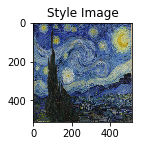

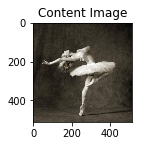

In [4]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

# plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
plt.subplot(2,1,1)
imshow(style_img, title='Style Image')

# plt.figure()
plt.subplot(2,1,2)
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()

        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)


    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product


    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


In [10]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

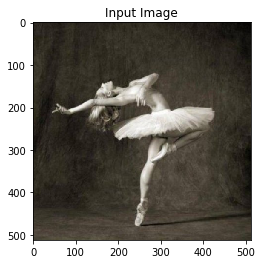

In [11]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000000, content_weight=1):
    """Run the style transfer."""
#     print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

#     print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
#             if run[0] % 50 == 0:
#                 print("run {}:".format(run))
#                 print('Style Loss : {:4f} Content Loss: {:4f}'.format(
#                     style_score.item(), content_score.item()))
#                 print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [18]:
# style_w = [100, 500, 1000, 5000, 10000, 50000,100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000]
# # style_imgs = ['the-starry-night.jpg!Large.jpeg', 'candy.jpg', 'style_input_2.jpg', 'still-life-vase-with-fifteen-sunflowers-1888-1.jpg!Large.jpeg']
# titles = ['starry_night', 'candy', 'sketch', 'sunflowers']
# for i in range(len(style_w)):
#     for j in range(4):
#         print('ratio: %s' %(style_w[i]))
#         style_img = image_loader("./images/the-starry-night.jpg!Large.jpeg")
#         output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                                     content_img, style_img, input_img, style_weight = style_w[i])

#         plt.figure()
#         imshow(output, title=titles[j])

#         # sphinx_gallery_thumbnail_number = 4
#         plt.ioff()
#         plt.show()

ratio: 100


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


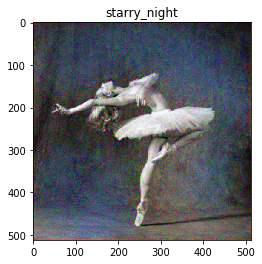

ratio: 500


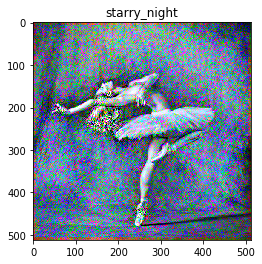

ratio: 1000


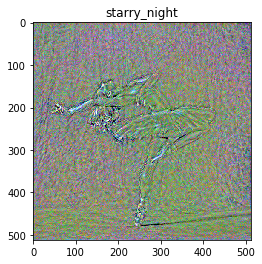

ratio: 5000


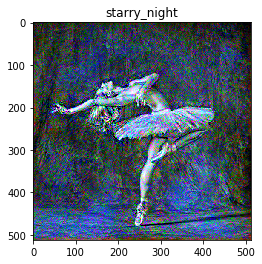

ratio: 10000


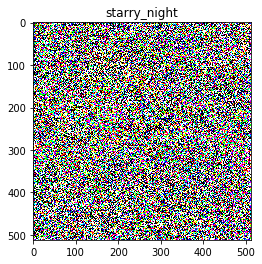

ratio: 50000


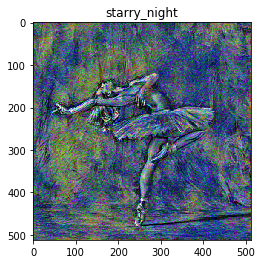

ratio: 100000


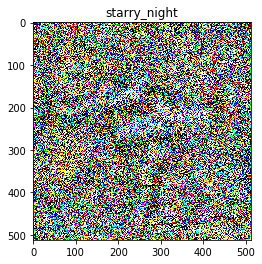

ratio: 500000


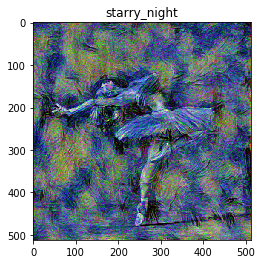

ratio: 1000000


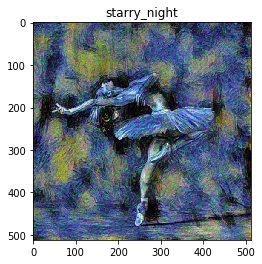

ratio: 5000000


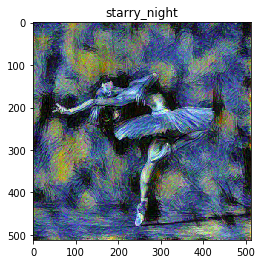

ratio: 10000000


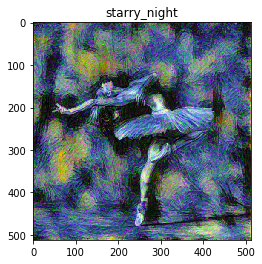

ratio: 50000000


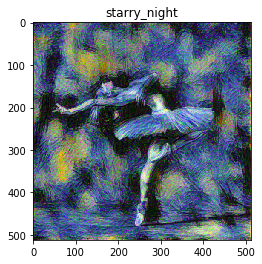

ratio: 100000000


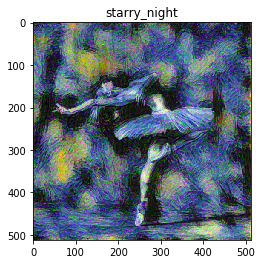

In [17]:
style_w = [100, 500, 1000, 5000, 10000, 50000,100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000]
# style_imgs = ['the-starry-night.jpg!Large.jpeg', 'candy.jpg', 'style_input_2.jpg', 'still-life-vase-with-fifteen-sunflowers-1888-1.jpg!Large.jpeg']
titles = ['starry_night', 'candy', 'sketch', 'sunflowers']
for i in range(len(style_w)):

    print('ratio: %s' %(style_w[i]))
    style_img = image_loader("./images/the-starry-night.jpg!Large.jpeg")
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, style_weight = style_w[i])

    plt.figure()
    imshow(output, title=titles[j])

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()